# **Stock Market Prediction**

In this notebook a basic **RNN model** is tested to do one-day ahead prediction. Also, we try different techniques to face the problems associated with gradients (vanishing and exploding gradient problems).


# **Load libraries and data**

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as weight_init
import datetime

# Set seed to reproducibility
torch.manual_seed(0)
random.seed(0)

In [2]:
 # Load data
 data = pd.read_csv('AAPL.csv')  
 # Convert Date to Date format
 data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Crop data to use stock values from 2006 onwards
data = data[data.Date>=datetime.datetime(2006,1,1)]

# Visualization of our data
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
6323,2006-01-03,10.340000,10.678572,10.321428,10.678572,9.269435,201808600
6324,2006-01-04,10.732857,10.854285,10.642858,10.710000,9.296719,154900900
6325,2006-01-05,10.690000,10.700000,10.535714,10.625714,9.223555,112355600
6326,2006-01-06,10.750000,10.957143,10.650000,10.900000,9.461646,176114400
6327,2006-01-09,10.961429,11.028571,10.820000,10.864285,9.430640,168760200


In [3]:
# Split data in training and test
data_train = data[data.Date<datetime.datetime(2019,1,1)]
data_test = data[data.Date>=datetime.datetime(2019,1,1)]

In [4]:
# For prediction, we go to use a window slice of different lenght. 
# We go to start with 20 samples (Open[0] to Open[19]). In this way, we can 
# predict the value 21 (Open[20]) and for next iteration, we take values
# Open[20] to Open[39] to predict Open[40] and so on.

# Now, first, we go to normalize data in a range of 0 to 1.

# Define min max scaler
scaler = MinMaxScaler(feature_range=(0,1))

# Scale data
data_train['Scaled Open'] = scaler.fit_transform(data_train[['Open']])
# Also, scale test data
data_test['Scaled Open'] = scaler.transform(data_test[['Open']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


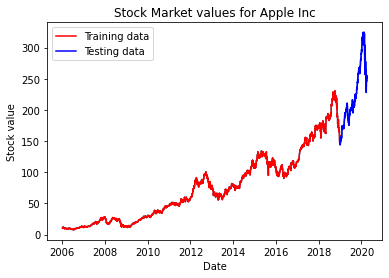

In [5]:
# Now, we go to check Open value in a plot 
plt.plot(data['Date'],data['Open'])
plt.plot(data_train['Date'],data_train['Open'],label = 'Training data', color='red')
plt.plot(data_test['Date'],data_test['Open'],label = 'Testing data', color='blue')
plt.xlabel('Date')
plt.ylabel('Stock value')
plt.title('Stock Market values for Apple Inc')
plt.legend()
plt.show()

In [6]:
# Extract data
train_values =  data_train[['Date','Scaled Open']]
test_values =  data_test[['Date','Scaled Open']]

# **Creation of useful functions to fit models**

In [7]:
# Prepare data

# First we need to set a sequence length
sequence_length = 50

# Other hyperparameters
input_size = 1
num_layers = 3
hidden_size = 50
num_epochs = 50
batch_size = 25 
learning_rate = 0.001

# Device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We go to create a class for read data
class ProcessingData(Dataset):
  def __init__(self,data,seq_length):
    # We go to pick our data values and take a window of values
    previous_days = []
    current_day = []
    # We go to keep date
    self.date = data[['Date']].values
    data = data[['Scaled Open']].values
    # Create sequence of previous and current data
    for day in range(len(data)-seq_length):
      previous_days.append(data[day:day+seq_length])
      current_day.append(data[seq_length+day])
    previous_days = np.array(previous_days)
    current_day = np.array(current_day)

    # Pass from list to tensors
    self.previous_days_data = torch.tensor(previous_days)
    self.current_day_data = torch.tensor(current_day)

  def __getitem__(self, idx): 
    previous_days = self.previous_days_data[idx]        
    current_day = self.current_day_data[idx]
    return previous_days,current_day

  def __len__(self):
    return len(self.current_day_data)

In [8]:
# Create dataset
train_dataset = ProcessingData(train_values,seq_length = sequence_length)
test_dataset = ProcessingData(test_values,seq_length = sequence_length)
# Apply dataloader
train_loader = DataLoader(train_dataset,batch_size = batch_size)
test_loader = DataLoader(test_dataset,batch_size = batch_size)

In [9]:
# Create class to train and predict in test
class StockPrediction():
  def __init__(self,model,train_data,test_data,sequential_length, clipping = 0):
    self.model = model
    self.train_data = train_data
    self.test_data = test_data
    self.sequential_lenght = sequential_length
    self.clipping = clipping

  # Train model
  def fit(self):
    # Loss and optimizer
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(self.model.parameters(), lr = 0.001)
    self.model.train()
    # We go to create a list to save gradients in our training step
    self.gradients = []
    self.mean_losses =[]
    for epoch in range(num_epochs):
      # Also, a list to save loss values is created
      losses = []
      for previous_days,current_day in self.train_data:
        previous_days = previous_days.float().to(device)
        current_day = current_day.float().to(device)
        outputs = self.model(previous_days)
        loss = criterion(outputs, current_day)
        optimizer.zero_grad()
        loss.backward()
        # Save loss value
        losses.append(loss.item())
        # Add graient clipping
        if self.clipping != 0:
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clipping)
        optimizer.step()
        # We go to calculate the gradients
        sum_gradients = 0
        number_parameters = 0
        for layers in rnn_testing.model.rnn.all_weights:
          for weights in layers:
            sum_gradients += weights.sum()
            number_parameters += torch.numel(weights)
        mean_grad = sum_gradients/number_parameters
        self.gradients.append(mean_grad.detach().numpy())
      self.mean_losses.append(sum(losses)/len(losses))

   # Prediction in training and testing  data
  def pred(self):
    self.model.eval()
    with torch.no_grad():
      counter = 0
      # Prediction in training
      for previous_days,current_day in self.train_data:
          previous_days = previous_days.float().to(device)
          current_day = current_day.float().to(device)
          outputs = self.model(previous_days)
          if counter == 0:
            self.predictions_train = outputs.clone()
          else:
            self.predictions_train = torch.cat((self.predictions_train,outputs))
          counter =+ 1
      # Prediction in testing
      counter = 0
      for previous_days,current_day in self.test_data:
          previous_days = previous_days.float().to(device)
          current_day = current_day.float().to(device)
          outputs = self.model(previous_days)
          if counter == 0:
            self.predictions_test = outputs.clone()
          else:
            self.predictions_test = torch.cat((self.predictions_test,outputs))
          counter =+ 1
      
  # Create plot of prediction
  def plot_pred_error(self,data_train,data_test):
    # Getting error in train
    error_mean_train = round(np.mean(abs(scaler.inverse_transform(rnn_testing.predictions_train)-data_train[['Open']][sequence_length:].values)),2)
    print('Mean Absolute Error in training: ', str(error_mean_train))
    # Getting error in test
    error_mean_test = round(np.mean(abs(scaler.inverse_transform(rnn_testing.predictions_test)-data_test[['Open']][sequence_length:].values)),2)
    print('Mean Absolute Error in testing: ', str(error_mean_test))
    # Create prediction plot
    figure, axis = plt.subplots(1, 2,figsize=(15, 5))
    axis[0].plot(data_train['Date'][sequence_length:],data_train['Open'][sequence_length:],label = 'True value')
    axis[0].plot(data_train['Date'][sequence_length:],scaler.inverse_transform(self.predictions_train),label = 'Prediction')
    axis[0].set_title("Prediction in  training")
    axis[0].set_ylim(0,350)
    axis[1].plot(data_test['Date'][sequence_length:],data_test['Open'][sequence_length:],label = 'True value')
    axis[1].plot(data_test['Date'][sequence_length:],scaler.inverse_transform(self.predictions_test),label = 'Prediction')
    axis[1].set_title("Prediction in  testing")
    axis[1].set_ylim(0,350)
    plt.legend(loc = 'upper left')
    plt.show()
  # create a plot of gradients during training
  def plot_gradients_losses(self):
    figure, axis = plt.subplots(1, 2,figsize=(15, 5))
    axis[0].plot(self.gradients)
    axis[0].set_title('Fit in training')
    axis[0].set_xlabel('Steps (Iterations)')
    axis[0].set_ylabel('Mean gradient value')
    axis[1].plot(self.mean_losses)
    axis[1].set_title('Training loss')
    axis[1].set_xlabel('Epochs')
    axis[1].set_ylabel('Loss value (mean)')
    plt.show()

# **Basic RNN**

In [10]:
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers):
    super(RNN,self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size,hidden_size,num_layers, batch_first = True,dropout = 0.1)
    self.fc = nn.Linear(hidden_size,1)
  def forward(self,x):
    #Initial hidden state
    h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
    out, _ = self.rnn(x,h0)
    out = out[:, -1,:] # We use only the values in last step
    out = self.fc(out)
    return out

In [11]:
# Create an instance of our model
rnn_model = RNN(input_size, hidden_size,num_layers).to(device)
rnn_testing = StockPrediction(rnn_model,train_loader,test_loader,sequential_length=sequence_length) 

In [12]:
rnn_testing.fit()

In [13]:
rnn_testing.pred()

Mean Absolute Error in training:  125.85
Mean Absolute Error in testing:  40.14


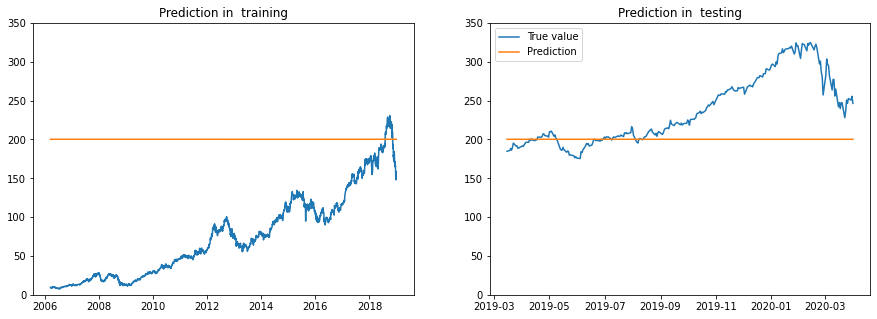

In [14]:
rnn_testing.plot_pred_error(data_train = data_train,data_test=data_test)

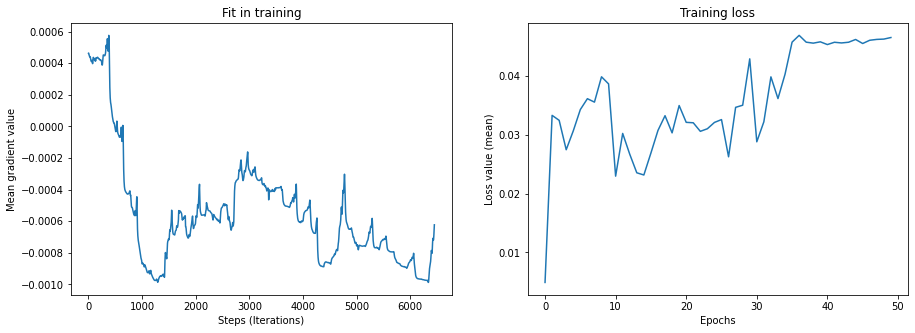

In [15]:
rnn_testing.plot_gradients_losses()

# **Basic RNN Using ReLU**

In [16]:
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers):
    super(RNN,self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size,hidden_size,num_layers, batch_first = True,nonlinearity = 'relu',dropout = 0.1)
    self.fc = nn.Linear(hidden_size,1)
  def forward(self,x):
    #Initial hidden state
    h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
    out, _ = self.rnn(x,h0)
    out = out[:, -1,:] # We use only the values in last step
    out = self.fc(out)
    return out

In [17]:
# Create an instance of our model
rnn_model = RNN(input_size, hidden_size,num_layers).to(device)
rnn_testing = StockPrediction(rnn_model,train_loader,test_loader,sequential_length=sequence_length) 

In [18]:
rnn_testing.fit()

In [19]:
rnn_testing.pred()

Mean Absolute Error in training:  15.51
Mean Absolute Error in testing:  26.3


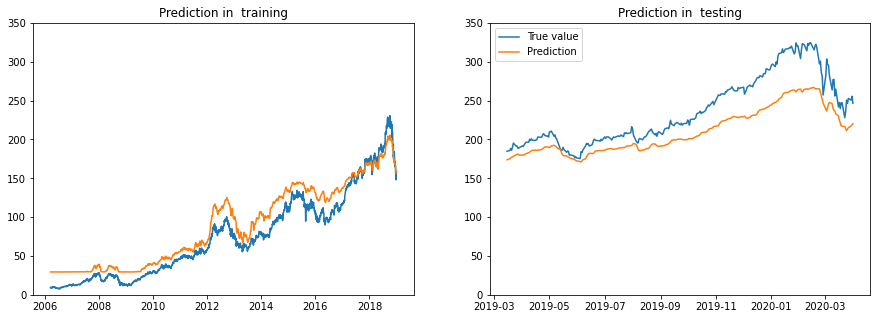

In [20]:
rnn_testing.plot_pred_error(data_train = data_train,data_test=data_test)

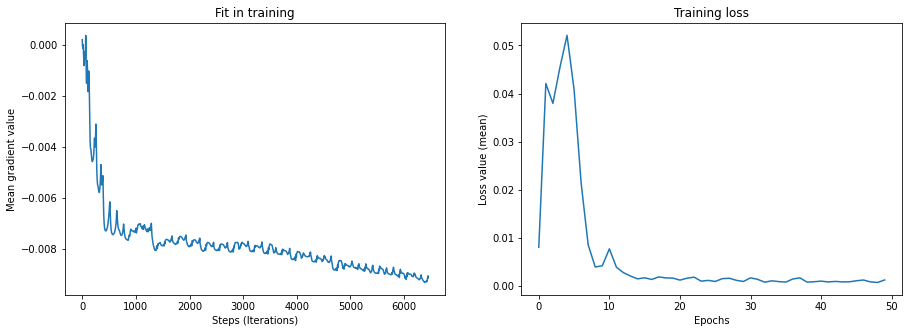

In [21]:
rnn_testing.plot_gradients_losses()

# **Basic RNN Using Identity Matrix Initialization**

In [22]:
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers):
    super(RNN,self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size,hidden_size,num_layers, batch_first = True,dropout = 0.1)
    self.fc = nn.Linear(hidden_size,1)
  def forward(self,x):
    #Initial hidden state
    h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
    out, _ = self.rnn(x,h0)
    out = out[:, -1,:] # We use only the values in last step
    out = self.fc(out)
    return out

In [23]:
# Create an instance of our model
rnn_model = RNN(input_size, hidden_size,num_layers).to(device)
rnn_testing = StockPrediction(rnn_model,train_loader,test_loader,sequential_length=sequence_length) 

# Initialize weights as identity matrix
for name, param in rnn_testing.model.rnn.named_parameters(): 
      # Set Whh as identity matrix
      if 'hh' in name and tuple(param.shape) == (hidden_size,hidden_size):
        param = nn.init.eye_(param)
      # Set bhh as zero
      if 'bias_hh' in name:
        param = nn.init.zeros_(param)

In [24]:
rnn_testing.fit()

In [25]:
rnn_testing.pred()

Mean Absolute Error in training:  120.04
Mean Absolute Error in testing:  43.78


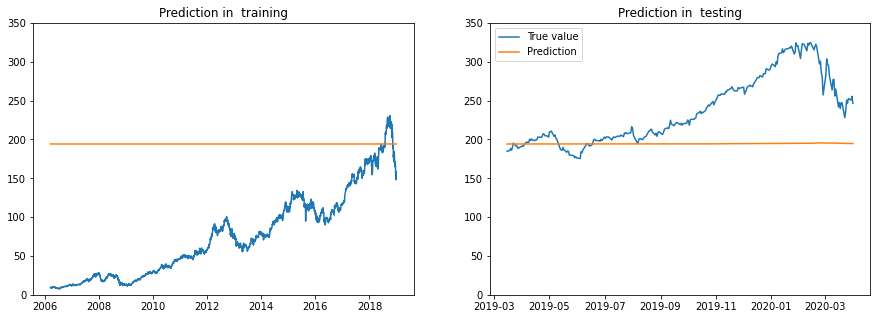

In [26]:
rnn_testing.plot_pred_error(data_train = data_train,data_test=data_test)

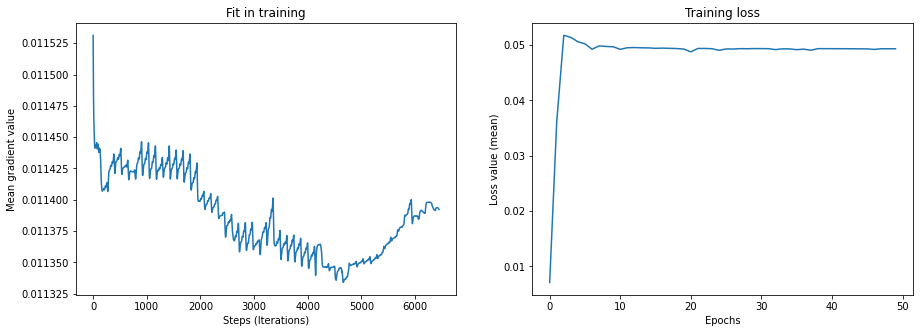

In [27]:
rnn_testing.plot_gradients_losses()

# **Basic RNN using Gradient clipping**

**Note**: It is ueful for tackling exploding gradient problem

In [28]:
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers):
    super(RNN,self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size,hidden_size,num_layers, batch_first = True,dropout = 0.1)
    self.fc = nn.Linear(hidden_size,1)
  def forward(self,x):
    #Initial hidden state
    h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
    out, _ = self.rnn(x,h0)
    out = out[:, -1,:] # We use only the values in last step
    out = self.fc(out)
    return out

In [29]:
# Create an instance of our model
rnn_model = RNN(input_size, hidden_size,num_layers).to(device)
rnn_testing = StockPrediction(rnn_model,train_loader,test_loader,sequential_length=sequence_length,clipping = 0.6) 

In [30]:
rnn_testing.fit()

In [31]:
rnn_testing.pred()

Mean Absolute Error in training:  12.44
Mean Absolute Error in testing:  20.3


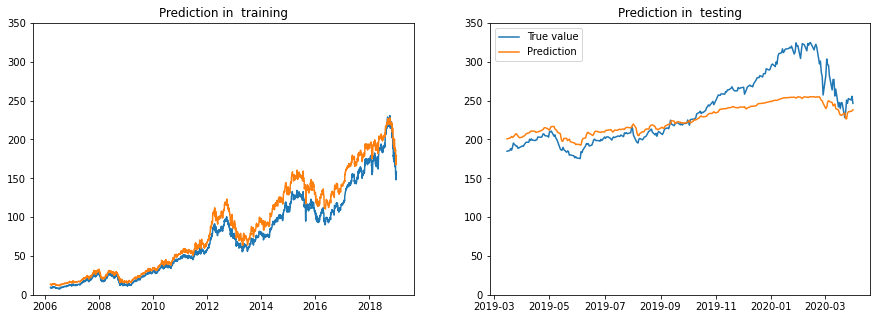

In [32]:
rnn_testing.plot_pred_error(data_train = data_train,data_test=data_test)

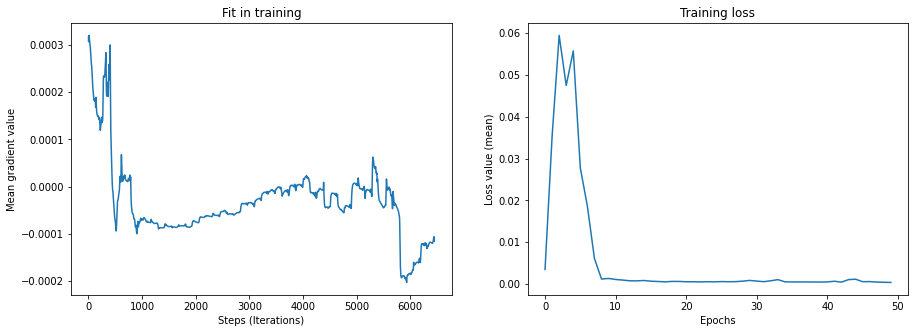

In [33]:
rnn_testing.plot_gradients_losses()